In [21]:
#python libraries
import os
import re
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Setting random seeds for reproducibility
random_seed = 420
np.random.seed(random_seed)
_ = torch.manual_seed(random_seed)

### DATA CLEANING

In [23]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### EXPLORATORY DATA ANALYSIS ###

<AxesSubplot:xlabel='timestamp'>

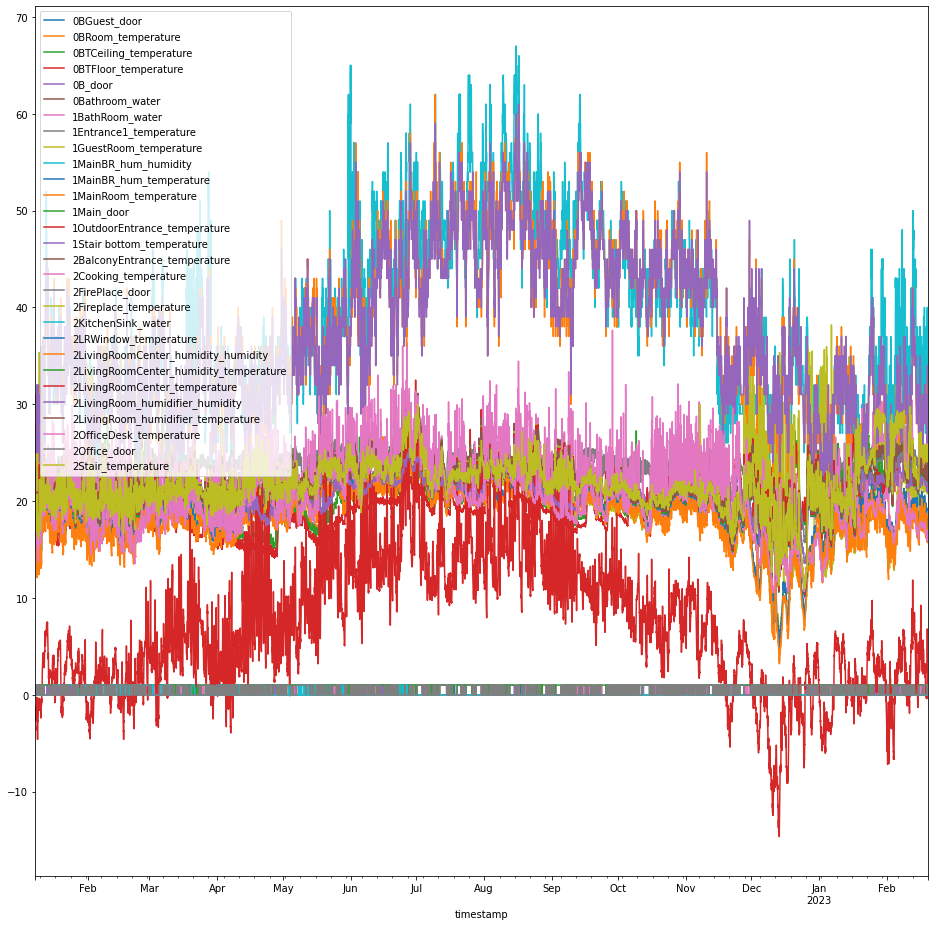

In [24]:
#plot the data
sensor_data.plot(figsize=(16, 16))

### FEATURE ENGINEERING ###

In [25]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [6]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [26]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [27]:
train_val_df = data.iloc[:int(data.shape[0]*0.9)]
test_df = data.iloc[int(data.shape[0]*0.9):]

train_val_split = int(train_val_df.shape[0]*0.8)
train_df = train_val_df[:train_val_split]
val_df = train_val_df[train_val_split:]

train_labels = train_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(train_df)
y_scaler.fit(train_labels)

train_df_scaled = x_scaler.fit_transform(train_df)
train_df_scaled = pd.DataFrame(train_df_scaled, columns=train_df.columns)
val_df_scaled = x_scaler.transform(val_df)
val_df_scaled = pd.DataFrame(val_df_scaled, columns=val_df.columns)
test_df_scaled = x_scaler.transform(test_df)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)


print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of labels = {train_labels.shape}")

Shape of train_df = (28199, 24), Shape of val_df = (7050, 24), Shape of test_df = (3917, 24)
Shape of labels = (28199, 12)


In [28]:
import WindowGenerator
import importlib
importlib.reload(WindowGenerator)

measurements_per_day = 4*24
sequence_width = 2*measurements_per_day
label_width = 8
shift = 0

train_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift, train_df_scaled, train_labels.columns)
val_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift, val_df_scaled, train_labels.columns)
test_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift, test_df_scaled, train_labels.columns)

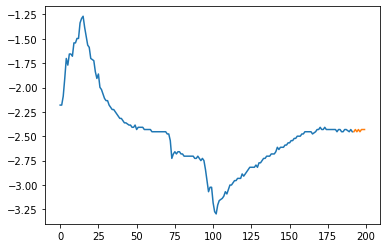

In [29]:
x_1 = train_windows[0][0][:,1]
x_2 = train_windows[0][1][:,0]
plt.plot(range(len(x_1)), x_1)
plt.plot(range(len(x_1), len(x_1)+len(x_2)), x_2)

In [11]:
batch_size = 1000
train_loader = DataLoader(train_windows, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_windows, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_windows, batch_size=len(test_windows), shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1000, 192, 24])
Target shape: torch.Size([1000, 8, 12])


### DOOR MODEL

In [30]:
feature_mask = train_df.columns.str.endswith('door')
feature_cols = [name for i, name in enumerate(train_df.columns) if not feature_mask[i]]

train_features_door = train_df[feature_cols].copy()
val_features_door = val_df[feature_cols].copy()
test_features_door = test_df[feature_cols].copy()

door_scaler = StandardScaler()

train_features_scaled_door = door_scaler.fit_transform(train_features_door)
val_features_scaled_door = door_scaler.transform(val_features_door)
test_features_scaled_door = door_scaler.transform(test_features_door)

train_labels_door = train_df.loc[:, train_df.columns.str.endswith('door')].values
val_labels_door = val_df.loc[:, val_df.columns.str.endswith('door')].values
test_labels_door = test_df.loc[:, test_df.columns.str.endswith('door')].values

In [31]:
y_train = torch.from_numpy(train_labels_door).to(torch.float)
x_train = torch.from_numpy(train_features_scaled_door).to(torch.float)

y_val = torch.from_numpy(val_labels_door).to(torch.float)
x_val = torch.from_numpy(val_features_scaled_door).to(torch.float)

y_test = torch.from_numpy(test_labels_door).to(torch.float)
x_test = torch.from_numpy(test_features_scaled_door).to(torch.float)

train_dataset_door = torch.utils.data.TensorDataset(x_train, y_train)
train_loader_door = torch.utils.data.DataLoader(train_dataset_door, batch_size=1048, shuffle=True)

val_dataset_door = torch.utils.data.TensorDataset(x_val, y_val)
val_loader_door = torch.utils.data.DataLoader(val_dataset_door, batch_size=len(x_val), shuffle=False)

In [32]:
import FFNNModel
import importlib
importlib.reload(FFNNModel)

layers = [train_features_door.shape[1], 128, 64, train_labels_door.shape[1]]
door_model = FFNNModel.Net(layers)
print(door_model)

train_door_model = False
if train_door_model:
    epochs = 10000
    lr = 1e-5
    l2_reg = 1e-4
    door_model.train(train_loader_door, val_loader_door, epochs, lr, l2_reg)
else:
    door_model.load_state_dict(torch.load('./models/door_model'))


Net(
  (linear_layers): ModuleList(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (act): ReLU()
  (sigmoid): Sigmoid()
)


### LSTM

In [28]:
import LSTMModel
import importlib
importlib.reload(LSTMModel)

model_3 = LSTMModel.Net(input_size=train_df.shape[1], hidden_size=64, output_shape=(label_width, train_labels.shape[1]),
                      num_lstm_layers=1, linear_layers=[64, 128, 128, 64])
print(model_3)

epochs = 100
lr = 0.001
l2_reg = 1e-9
model_3.train(train_loader, val_loader, epochs, lr, l2_reg)

Net(
  (lstm): LSTM(24, 64, batch_first=True)
  (linear_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=96, bias=True)
  )
  (act): ReLU()
)
Epoch: 1, Test loss: 0.5796388983726501
Epoch: 1: Val MSE: 22.873598098754883
Epoch: 2, Test loss: 0.22380758821964264
Epoch: 2: Val MSE: 13.368385314941406
Epoch: 3, Test loss: 0.1464201807975769
Epoch: 3: Val MSE: 9.494526863098145
Epoch: 4, Test loss: 0.10181085765361786
Epoch: 4: Val MSE: 7.27056360244751
Epoch: 5, Test loss: 0.07718843221664429
Epoch: 5: Val MSE: 5.802209377288818
Epoch: 6, Test loss: 0.07010022550821304
Epoch: 6: Val MSE: 5.391870975494385
Epoch: 7, Test loss: 0.06176362559199333
Epoch: 7: Val MSE: 5.097262382507324
Epoch: 8, Test loss: 0.05688902735710144
Epoch: 8: V

In [44]:
save = True
if save:
    torch.save(model_3.state_dict(), f'./models/8_step_model')

### EXAMINE MODEL

In [36]:
predictions = []
ground_truth = []
for input, label in val_loader:
    pred = model(input)
    predictions.append(y_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 12)))
    ground_truth.append(y_scaler.inverse_transform(label.reshape(-1, 12)))


predictions = np.array(predictions[:-1])
ground_truth = np.array(ground_truth[:-1])

print('Error on validation data')

mse_val = np.mean(np.power((predictions - ground_truth), 2))
print(f'MSE:  {mse_val.item()}')

mae_val = np.mean(np.abs(predictions - ground_truth))
print(f'MAE:  {mae_val.item()}')

mape_val = 100*np.mean(np.abs(np.divide(predictions - ground_truth, ground_truth)))
print(f'MAPE: {mape_val.item()} %')

Error on validation data
MSE:  2.0569532432709687
MAE:  0.8935617055725237
MAPE: 5.7899533505280765 %


### FORECAST

In [45]:
def rolling_forecast(model, door_model, start_window, future_windows, steps, timesteps_per_step):
    temp_mask = [(column in train_labels) for column in data.columns]
    temp_indices = [i for i, x in enumerate(temp_mask) if x == True]

    cols_to_update = ['1OutdoorEntrance_temperature', 'sin_daily', 'cos_daily', 'sin_yearly',
                    'cos_yearly', 'sin_weekly', 'cos_weekly']
    cols_to_update_mask = [(column in cols_to_update) for column in data.columns]
    cols_to_update_indices = [i for i, x in enumerate(cols_to_update_mask) if x == True]

    door_mask = train_df.columns.str.endswith('door')
    door_indices = [i for i, name in enumerate(train_df.columns) if door_mask[i]]
    not_door_indices = [i for i, name in enumerate(train_df.columns) if not door_mask[i]]

    current_window = start_window.clone()

    predictions = []
    ground_truth = []
    for i in range(steps):
        next_pred = model(current_window.reshape(1, current_window.shape[0], current_window.shape[1]))
        next_state = current_window[-timesteps_per_step:].clone()
        
        for label_index, window_index in enumerate(temp_indices):
            for n, row in enumerate(next_pred[0]):
                next_state[n][window_index] = row[label_index]
        
        for window_index in cols_to_update_indices:
            for n in range(timesteps_per_step):
                if window_index == cols_to_update_indices[0]:
                    bias = float(np.random.randint(75, 125))/100
                    next_state[n][window_index] = bias*future_windows[timesteps_per_step*(i+1)][0][-(timesteps_per_step-n)][window_index]
                else:
                    next_state[n][window_index] = future_windows[timesteps_per_step*(i+1)][0][-(timesteps_per_step-n)][window_index]
        
        doors_removed = next_state[0, not_door_indices]
        door_pred = door_model(doors_removed).round()
        for door_index, window_index in enumerate(door_indices):
            for n in range(timesteps_per_step):
                next_state[n][window_index] = door_pred[door_index]
        current_window = torch.roll(current_window, -timesteps_per_step, dims=0)
        current_window[-timesteps_per_step:] = next_state

        predictions.append(next_pred[0].detach().numpy())
        ground_truth.append(future_windows[timesteps_per_step*(i+1)][0][-timesteps_per_step:, temp_indices].detach().numpy())
    
    for i in range(len(ground_truth)):
        ground_truth[i] = y_scaler.inverse_transform(ground_truth[i])
        predictions[i] = y_scaler.inverse_transform(predictions[i])

    input_seq = x_scaler.inverse_transform(start_window.detach().numpy())
    temp_input_seq = []
    for input in input_seq:
        temp_input_seq.append(np.array(input[temp_indices]))
    
    predictions = np.array(predictions).reshape(-1, 12).T
    ground_truth = np.array(ground_truth).reshape(-1, 12).T
    temp_input_seq = np.array(temp_input_seq).reshape(-1, 12).T
    
    return predictions, ground_truth, temp_input_seq

### 1 DAY FORECAST

In [46]:
steps_per_pred = 8
eight_step_model = LSTMModel.Net(input_size=train_df.shape[1], hidden_size=64, output_shape=(label_width, train_labels.shape[1]),
                      num_lstm_layers=1, linear_layers=[64, 128, 128, 64])
eight_step_model.load_state_dict(torch.load('./models/8_step_model'))
steps_per_day = 12
pred_steps = steps_per_day
num_pred = 50

used_windows = test_windows

np.random.seed(random_seed)
eval_windows_index = np.random.choice(range(0, len(used_windows)-pred_steps*steps_per_pred-1), num_pred)

predictions = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
ground_truths = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
temp_input_seqs = np.zeros((num_pred, used_windows[0][1].shape[1], used_windows[0][0].shape[0]))

for i, start_index in enumerate(eval_windows_index):
    start_window = used_windows[start_index][0]
    future_window = used_windows[start_index:start_index+steps_per_pred*pred_steps+1]
    prediction, ground_truth, temp_input_seq = rolling_forecast(eight_step_model, door_model, start_window, future_window, pred_steps, steps_per_pred)
    predictions[i] = prediction
    ground_truths[i] = ground_truth
    temp_input_seqs[i] = temp_input_seq
    print(f"Start index: {start_index}, Forecast MAE:  {np.mean(np.abs(ground_truth - prediction))}")

print(f'Avg forecast MAE: {np.mean(np.abs(ground_truths-predictions))}')
pbm_indices = [0, 1, 2, 3, 4, 5, 6, 9, 10]
print(f'Avg forecast MAE for sensors used in PBM: {np.mean(np.abs(ground_truths[:, pbm_indices] - predictions[:, pbm_indices]))}')

Start index: 2993, Forecast MAE:  1.8136229515075684
Start index: 1096, Forecast MAE:  1.4203122854232788
Start index: 390, Forecast MAE:  1.2402046918869019
Start index: 575, Forecast MAE:  1.2384039163589478
Start index: 799, Forecast MAE:  1.769757628440857
Start index: 2675, Forecast MAE:  1.5024676322937012
Start index: 1966, Forecast MAE:  1.2433580160140991
Start index: 1209, Forecast MAE:  1.5596508979797363
Start index: 2202, Forecast MAE:  2.037907123565674
Start index: 266, Forecast MAE:  0.9815787076950073
Start index: 840, Forecast MAE:  1.7977523803710938
Start index: 2711, Forecast MAE:  1.3529608249664307
Start index: 1678, Forecast MAE:  2.0284125804901123
Start index: 1254, Forecast MAE:  1.7078722715377808
Start index: 724, Forecast MAE:  2.269663095474243
Start index: 803, Forecast MAE:  1.7688124179840088
Start index: 152, Forecast MAE:  1.2824726104736328
Start index: 1668, Forecast MAE:  1.996521234512329
Start index: 2901, Forecast MAE:  2.2061195373535156
Start

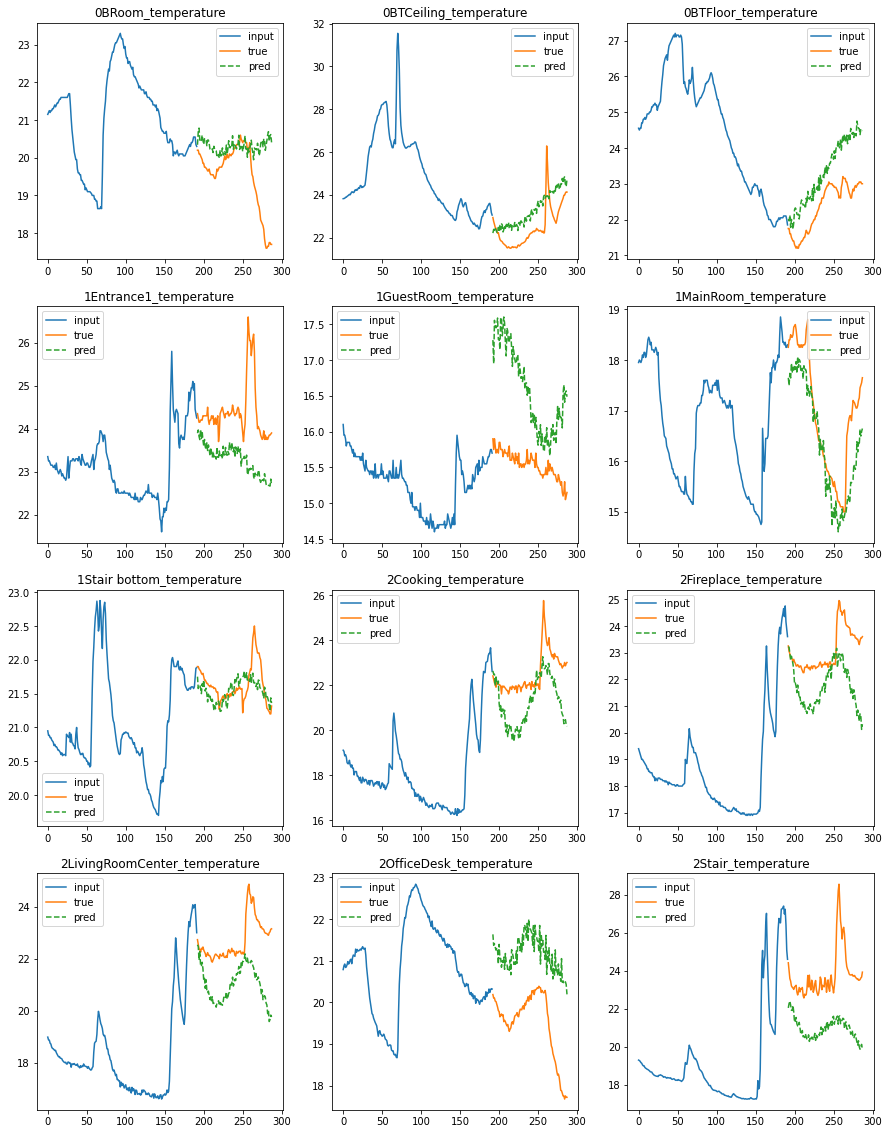

In [47]:
plot_i = 3
fig,ax = plt.subplots(4,3,figsize=(15,20))
for i in range(predictions_1_day.shape[1]):
    input_indices = range(len(start_window))
    pred_indices = range(len(input_indices), len(input_indices) + 8*12)
    ax[i//3, i%3].plot(input_indices, temp_input_seqs_1_day[plot_i][i], label="input")
    ax[i//3, i%3].plot(pred_indices, ground_truths_1_day[plot_i][i], label="true")
    ax[i//3, i%3].plot(pred_indices, predictions_1_day[plot_i][i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()

### 2 DAYS FORECAST

In [48]:
steps_per_pred = 8
eight_step_model = LSTMModel.Net(input_size=train_df.shape[1], hidden_size=64, output_shape=(label_width, train_labels.shape[1]),
                      num_lstm_layers=1, linear_layers=[64, 128, 128, 64])
eight_step_model.load_state_dict(torch.load('./models/8_step_model'))
steps_per_day = 12
pred_steps = steps_per_day*2
num_pred = 50

used_windows = test_windows

np.random.seed(random_seed)
eval_windows_index = np.random.choice(range(0, len(used_windows)-pred_steps*steps_per_pred-1), num_pred)

predictions = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
ground_truths = np.zeros((num_pred, used_windows[0][1].shape[1], pred_steps*steps_per_pred))
temp_input_seqs = np.zeros((num_pred, used_windows[0][1].shape[1], used_windows[0][0].shape[0]))

for i, start_index in enumerate(eval_windows_index):
    start_window = used_windows[start_index][0]
    future_window = used_windows[start_index:start_index+steps_per_pred*pred_steps+1]
    prediction, ground_truth, temp_input_seq = rolling_forecast(eight_step_model, door_model, start_window, future_window, pred_steps, steps_per_pred)
    predictions[i] = prediction
    ground_truths[i] = ground_truth
    temp_input_seqs[i] = temp_input_seq
    print(f"Start index: {start_index}, Forecast MAE:  {np.mean(np.abs(ground_truth - prediction))}")

print(f'Avg forecast MAE: {np.mean(np.abs(ground_truths-predictions))}')
pbm_indices = [0, 1, 2, 3, 4, 5, 6, 9, 10]
print(f'Avg forecast MAE for sensors used in PBM: {np.mean(np.abs(ground_truths[:, pbm_indices] - predictions[:, pbm_indices]))}')

Start index: 2993, Forecast MAE:  1.6770339012145996
Start index: 1096, Forecast MAE:  1.6150370836257935
Start index: 390, Forecast MAE:  1.7978218793869019
Start index: 575, Forecast MAE:  1.959150791168213
Start index: 799, Forecast MAE:  1.957812786102295
Start index: 2675, Forecast MAE:  1.576854944229126
Start index: 1966, Forecast MAE:  1.5399671792984009
Start index: 1209, Forecast MAE:  1.810081958770752
Start index: 2202, Forecast MAE:  2.494642972946167
Start index: 266, Forecast MAE:  1.1130982637405396
Start index: 840, Forecast MAE:  2.071619987487793
Start index: 2711, Forecast MAE:  1.6001774072647095
Start index: 1678, Forecast MAE:  2.1060397624969482
Start index: 1254, Forecast MAE:  1.9985885620117188
Start index: 724, Forecast MAE:  2.61726713180542
Start index: 803, Forecast MAE:  1.95945405960083
Start index: 152, Forecast MAE:  1.5591106414794922
Start index: 1668, Forecast MAE:  2.102505683898926
Start index: 2901, Forecast MAE:  2.1558892726898193
Start index:

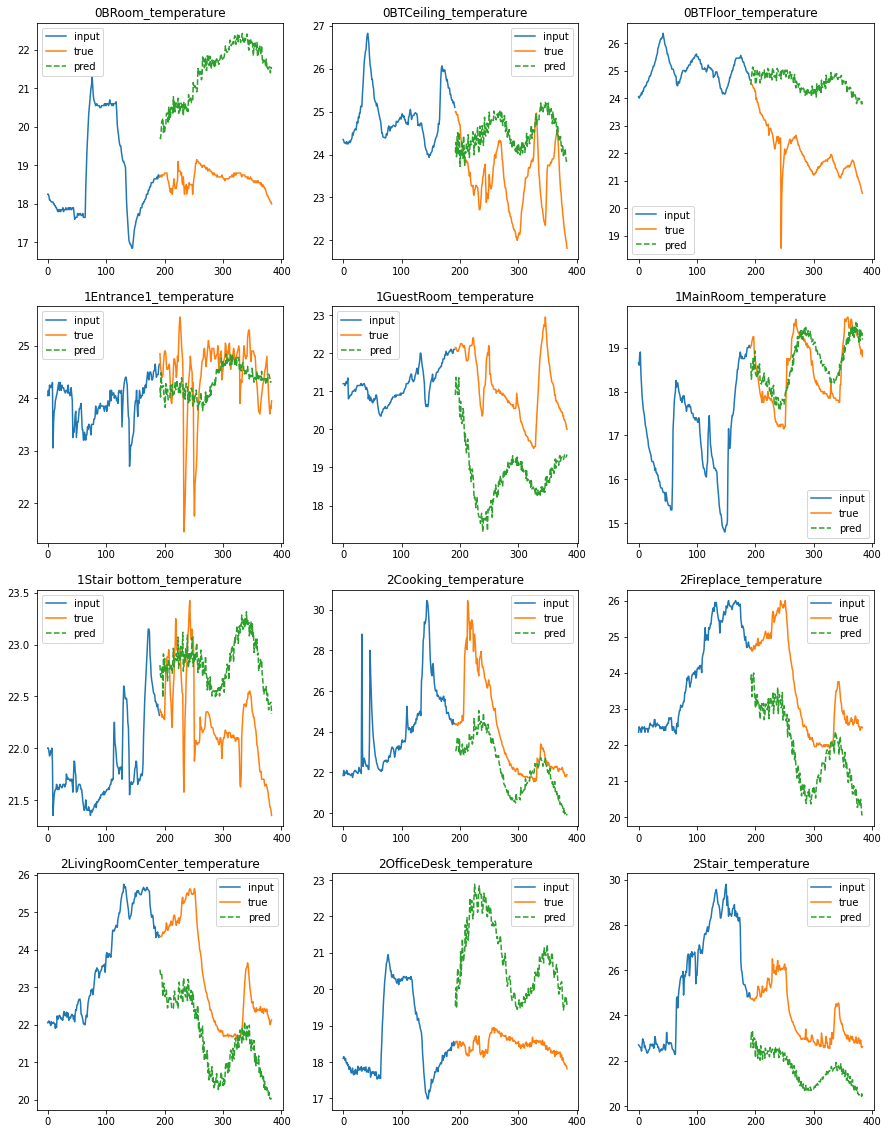

In [49]:
plot_i = 0
fig,ax = plt.subplots(4,3,figsize=(15,20))
for i in range(predictions_2_day.shape[1]):
    input_indices = range(len(start_window))
    pred_indices = range(len(input_indices), len(input_indices) + 8*24)
    ax[i//3, i%3].plot(input_indices, temp_input_seqs_2_day[plot_i][i], label="input")
    ax[i//3, i%3].plot(pred_indices, ground_truths_2_day[plot_i][i], label="true")
    ax[i//3, i%3].plot(pred_indices, predictions_2_day[plot_i][i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()